# Titanic First Pass Analysis

This analysis is a demo to practice basic data analysis skills with Pandas, NumPy, and matplotlib as part of Udacity's Intro to Data Analysis course. Various data wrangling, data analysis, and data visualization techniques will be explored on a real world data set. Additionally, this project will give practice with using Jupyter Notebooks to present findings. As this is a first pass analysis, there will be no machine learning techniques or statistical analysis performed.

The data set is the popular "Titanic Data Set" as found on [Kaggle](https://www.kaggle.com/c/titanic/data). The data contains passenger information and survival data from 891 of the 2224 passengers. This set contains features such as age, sex, and ticket class. 

The goal of the analysis is to find inital trends and correlations between these features and passenger survival. Three initial questions that can give guidance on further analysis are the following:

1. Does a higher Pclass correlate with a higher survival rate?
2. Were females more likely to have survived?
3. Were children under 18 more likely to have survived?



## 0. Data information

Taken from the [Kaggle](https://www.kaggle.com/c/titanic/data) description.
#### **Data Dictionary**

|**Variable**|**Definition**|	      Key
|:-|--------------|
|*survival*| Survival|  0 = No, 1 = Yes
|*pclass*| Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd
|*sex*| Sex|	
|*Age*|	Age in years	
|*sibsp*| # of siblings / spouses aboard the Titanic	
|*parch*| # of parents / children aboard the Titanic	
|*ticket*| Ticket number	
|*fare*| Passenger fare	
|*cabin*| Cabin number	
|*embarked*| Port of Embarkation| C = Cherbourg, Q = Queenstown, S = Southampton

#### **Variable Notes**

**pclass**: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore parch=0 for them.

## 1. Process the data

### Load data

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('titanic_data.csv')

data = data.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)

### Clean Data

The first step needed for cleaning the data set is to look at the data. A good feel of what is available and if there are any strange values is a good start in identifying what needs to be cleaned. The two methods `data.head()` and `data.describe()` will do this. The first will print the first 5 lines of the DataFrame, while the second gives basic statistics of each column.

In [3]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


When looking at the output from `data.head()`, the 'Sex' feature's data type is string. It will be easier to manipulate this later if it is changed to a binary value. 

In [5]:
data['Sex_binary'] = data['Sex'].map({'male': 1, 'female': 0})

When looking at the output from `data.describe()`, the number of entries in 'Age' is less than the number of entries in the other features, which suggests there are missing values. Missing values will be set to a default value of 0. 

'PassengerId' can be set as the index of the DataFrame, as it appears there is a unique entry for each passenger.

To get a feel for the data, it appears that 38% of the roster did not survive. This analysis will look for commonalities in this group.


In [6]:
data['Age'] = data['Age'].fillna(0)

data = data.set_index('PassengerId')

# Check to see if any null values still exist
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_binary    0
dtype: int64

In [7]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Sex_binary
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,1
2,1,1,female,38.0,1,0,71.2833,0
3,1,3,female,26.0,0,0,7.9250,0
4,1,1,female,35.0,1,0,53.1000,0
5,0,3,male,35.0,0,0,8.0500,1


## 2. Explore the data

Class 1 survival rate for females: 96.8%
Class 1 survival rate for males: 36.9%
Class 2 survival rate for females: 92.1%
Class 2 survival rate for males: 15.7%
Class 3 survival rate for females: 50.0%
Class 3 survival rate for males: 13.5%


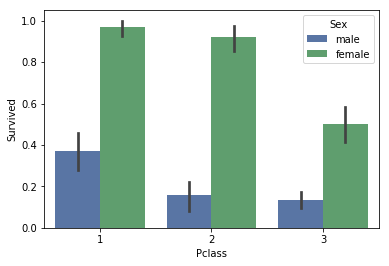

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

def survival_rate(df, pclass, cat2_label, cat2_value):
    """
    df: DataFrame
    pclass: class value 1, 2, or 3
    cat2_label: Second category, such as 'Sex'
    cat2_value: Value for cat2_label, such as 'male' or 'female'
    return: percent of people survived over total
    """
    group_by_total = df.groupby(['Pclass', cat2_label]).size()[pclass, cat2_value]
    group_by_survived = df.groupby(['Pclass', cat2_label, 'Survived']).size()[pclass, cat2_value, 1]
    return group_by_survived / group_by_total*100

for pclass in np.sort(data.Pclass.unique()):
    for sex in np.sort(data.Sex.unique()):
        print('Class {0} survival rate for {1}s: {2:.1f}%'.format(pclass, sex, survival_rate(data, pclass, 'Sex', sex)))

current_palette = sns.color_palette("deep")
sns.set_palette(current_palette)

graph = sns.barplot(x="Pclass", y="Survived", hue="Sex", data=data)

The chart above indicates as Pclass of the passenger increases, survival rates decrease. This suggests the more wealthy passengers were able to secure a spot on the life boats over the middle class passengers. Likewise, there is a larger proportion of females than males who survived. This trend is present regardless of the Pclass of the passenger.

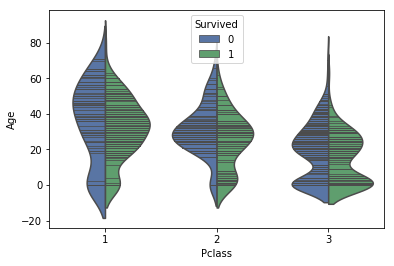

In [22]:
age_graph = sns.violinplot(x="Pclass", y="Age", hue="Survived", data=data, split=True, inner="stick")

Class 1 survival rate when age >= 18 is False: 59.5%
Class 1 survival rate when age >= 18 is True: 63.8%
Class 2 survival rate when age >= 18 is False: 73.5%
Class 2 survival rate when age >= 18 is True: 41.3%
Class 3 survival rate when age >= 18 is False: 29.4%
Class 3 survival rate when age >= 18 is True: 20.2%


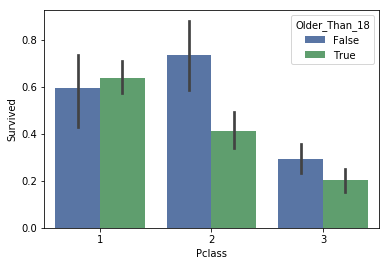

In [23]:
above_18 = data.copy()
above_18['Older_Than_18'] = data['Age'].map(lambda x: x>=18)

for pclass in np.sort(above_18.Pclass.unique()):
    for age_class in np.sort(above_18.Older_Than_18.unique()):
        print('Class {0} survival rate when age >= 18 is {1}: {2:.1f}%'.format(pclass, age_class, survival_rate(above_18, pclass, 'Older_Than_18', age_class)))
        
age_bar_graph = sns.barplot(x="Pclass", y="Survived", hue="Older_Than_18", data=above_18)

The violin plot and bar plot above shows how age, in combination with class played a role in survival. Although age is not a large factor when the passenger was in first class, children from the second class were more likely to live than adults in second class. Although there is a slightly higher survival rate for children in third class than adults in third class, the difference is not as wide as from second class. 